In [1]:
import pandas as pd
import numpy as np
from numpy import mean, std
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score 
from sklearn.preprocessing import StandardScaler, RobustScaler
from skopt.searchcv import BayesSearchCV
from skopt.space import Integer, Real, Categorical 
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence
from deezerData import readData

import warnings
warnings.filterwarnings("ignore")

## Read Data

In [3]:
df, X, y, X_train, X_test, y_train, y_test = readData()
df.head()

,genre_id,ts_listen,media_id,album_id,context_type,release_date,platform_name,platform_family,media_duration,listen_type,user_gender,user_id,artist_id,user_age,is_listened
9,7,1479214304,542335,71718,1,20080215,1,2,150,1,1,51,2939,28,1
17,7,1478892170,542335,71718,14,20080215,2,1,150,0,0,336,2939,20,1
25,7,1478079016,542346,71718,3,20080215,2,1,197,0,0,65,2939,26,1
26,7,1478085122,542340,71718,3,20080215,2,1,210,0,0,65,2939,26,1
27,7,1478084056,542347,71718,3,20080215,2,1,188,0,0,65,2939,26,1


## Evaluate the best hyperparameters
according to: https://medium.datadriveninvestor.com/alternative-hyperparameter-optimization-techniques-you-need-to-know-part-2-e9b0d4d080a9 
#### Approach 1: Use BayesSearchCV

In [4]:
params = {"n_estimators": [100, 200, 300, 400],
          "max_depth": (1, 9),
          "criterion": ["gini", "entropy"]
}

search_space = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=params,
    n_jobs=1,
    cv=5,
    n_iter=30,
    scoring="roc_auc",
    verbose=4,
    random_state=42
)

search_space.fit(X_train, y_train)
print(search_space.best_score_)
print(search_space.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.835 total time=   1.7s
[CV 2/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.820 total time=   1.7s
[CV 3/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.815 total time=   1.7s
[CV 4/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.826 total time=   1.7s
[CV 5/5] END criterion=entropy, max_depth=7, n_estimators=400;, score=0.832 total time=   1.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.845 total time=   0.7s
[CV 2/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.826 total time=   0.7s
[CV 3/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.824 total time=   0.7s
[CV 4/5] END criterion=gini, max_depth=8, n_estimators=200;, score=0.834 total time=   0.7s
[CV 5/5] END criterion=gini, max_depth=

[CV 4/5] END criterion=entropy, max_depth=6, n_estimators=200;, score=0.817 total time=   0.7s
[CV 5/5] END criterion=entropy, max_depth=6, n_estimators=200;, score=0.825 total time=   0.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.849 total time=   1.7s
[CV 2/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.834 total time=   1.7s
[CV 3/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.834 total time=   1.7s
[CV 4/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.844 total time=   1.7s
[CV 5/5] END criterion=gini, max_depth=9, n_estimators=400;, score=0.847 total time=   1.7s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END criterion=entropy, max_depth=4, n_estimators=300;, score=0.811 total time=   0.9s
[CV 2/5] END criterion=entropy, max_depth=4, n_estimators=300;, score=0.801 total time=   0.8s
[CV 3/5] END criterion=entropy, max_depth=

In [5]:
print(search_space.best_estimator_)
print(search_space.best_params_)

RandomForestClassifier(max_depth=9, n_estimators=400)
OrderedDict([('criterion', 'gini'), ('max_depth', 9), ('n_estimators', 400)])


#### Approach 2: Perform optimization using Gaussian Process, define a function to minimize (*gp_minimize*)

In [6]:
search_space = list()
search_space.append(Categorical([100, 200, 300, 400], name='n_estimators'))
search_space.append(Categorical(['gini', 'entropy'], name='criterion'))
search_space.append(Integer(1, 9, name='max_depth'))

@use_named_args(search_space)
def evaluate_model(**params):
    clf = RandomForestClassifier(**params, n_jobs=-1)
    rocauc = cross_val_score(clf, X_train, y_train, scoring="roc_auc").mean()
    return -rocauc

In [7]:
result = gp_minimize(
    func=evaluate_model,
    dimensions=search_space,
    n_calls=30,
    random_state=42,
    verbose=True,
    n_jobs=1,
)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 2.6528
Function value obtained: -0.8258
Current minimum: -0.8258
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.3429
Function value obtained: -0.7930
Current minimum: -0.8258
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9352
Function value obtained: -0.7923
Current minimum: -0.8258
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.4890
Function value obtained: -0.8262
Current minimum: -0.8262
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.2361
Function value obtained: -0.8396
Current minimum: -0.8396
Iteration No: 6 started. 

In [8]:
print('Best AUC: %.3f' % (result.fun)) 
print('Best Parameters: %s' % (result.x))
print(result.func_vals)

Best AUC: -0.842
Best Parameters: [400, 'gini', 9]
[-0.82580465 -0.79302614 -0.79227565 -0.82616031 -0.83958383 -0.78293482
 -0.80444597 -0.79557985 -0.8031201  -0.83274691 -0.83799536 -0.84140668
 -0.84063726 -0.8410302  -0.83947989 -0.84173696 -0.84109778 -0.83911123
 -0.79109305 -0.83858551 -0.84086418 -0.84179756 -0.81973987 -0.81087537
 -0.8334537  -0.83966548 -0.83911326 -0.8194886  -0.84173009 -0.835216  ]


<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

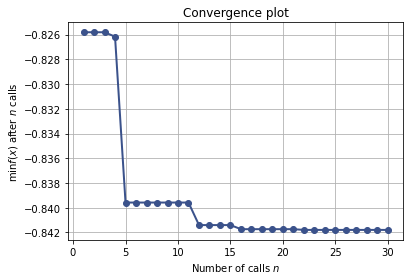

In [9]:
plot_convergence(result) 

## Assign model, fit and predict

In [10]:
## assign model
model = RandomForestClassifier(n_estimators=400, max_depth=9, criterion="gini")

## cross validation
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', 
                           cv=cv, n_jobs=-1, error_score='raise')
print(f"ROC AUC [mean (sd)]: {mean(n_scores).round(4)} ({std(n_scores).round(4)})")

ROC AUC [mean (sd)]: 0.8438 (0.0114)


In [11]:
## fit model
model.fit(X_train, y_train)

## make prediction
y_pred = model.predict(X_test)

## evaluate quality of prediction
metrics.roc_auc_score(y_test, y_pred), metrics.accuracy_score(y_test, y_pred)

(0.729342579169967, 0.7833655705996132)